In [5]:
from src.data_utils import *
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploratory Data Analysis

Visualize relationships between atmospheric variables and sea ice extent to identify potential predictive features.

In [35]:
data = load_data_for_year(2000, 'Central')
data = pd.concat([data, load_data_for_year(2001, 'Central')])

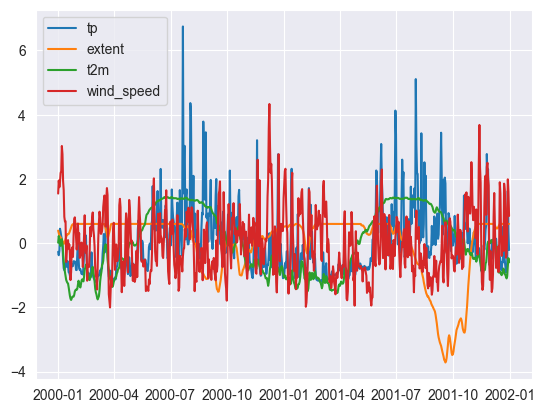

In [38]:
plt.plot(data['date'], (data['tp_mean'] - data['tp_mean'].mean()) / data['tp_mean'].std())
plt.plot(data['date'], (data['extent'] - data['extent'].mean()) / data['extent'].std())
plt.plot(data['date'], (data['t2m_mean'] - data['t2m_mean'].mean()) / data['t2m_mean'].std())
plt.plot(data['date'], (data['wind_speed_mean'] - data['wind_speed_mean'].mean()) / data['wind_speed_mean'].std())
plt.legend(['tp', 'extent', 't2m', 'wind_speed'])